In [1]:
# Authors: N. Branson, W. Connell, A. Wenteler

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import auc
import scipy.stats as stats
import matplotlib.pyplot as plt
from pypalettes import load_cmap
import gzip 
import pickle as pkl 
import os
import mpl_sizes
from collections import defaultdict
import math

formatter = mpl_sizes.get_format("NeurIPS") # options: ICLR, ICML, NeurIPS, InfThesis

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Compare Aggregate deltaAUSPC to Perturbation-level deltaAUSPC

In [104]:
df_mean_ind = pd.read_csv('individual_results/1-gene/pert_level_mean_non_adj_full.csv')
df_raw_ind = pd.read_csv('individual_results/1-gene/pert_level_raw_exp_non_adj_full.csv')
df_uce_ind = pd.read_csv('individual_results/1-gene/pert_level_uce_non_adj_full.csv')
df_scgpt_ind = pd.read_csv('individual_results/1-gene/pert_level_scgpt_non_adj_full.csv')
df_gf_ind = pd.read_csv('individual_results/1-gene/pert_level_gf_non_adj_full.csv')
df_scf_ind = pd.read_csv('individual_results/1-gene/pert_level_scfoundation_non_adj_full.csv')
df_scbert_ind = pd.read_csv('individual_results/1-gene/pert_level_scbert_non_adj_full.csv')

df_mean_agg = pd.read_csv('aggregated_results/1-gene/mean.csv')
df_raw_agg = pd.read_csv('aggregated_results/1-gene/mlp_baseline.csv')
df_uce_agg = pd.read_csv('aggregated_results/1-gene/uce.csv')
df_scgpt_agg = pd.read_csv('aggregated_results/1-gene/scgpt.csv')
df_gf_agg = pd.read_csv('aggregated_results/1-gene/gf.csv')
df_scf_agg = pd.read_csv('aggregated_results/1-gene/scfoundation.csv')
df_scbert_agg = pd.read_csv('aggregated_results/1-gene/scbert.csv')

df_mean_ind_two_gene = pd.read_csv('individual_results/2-gene/mean.csv')
df_raw_ind_two_gene = pd.read_csv('individual_results/2-gene/raw_exp.csv')
df_uce_ind_two_gene = pd.read_csv('individual_results/2-gene/uce.csv')
df_scgpt_ind_two_gene = pd.read_csv('individual_results/2-gene/scgpt.csv')
df_gf_ind_two_gene = pd.read_csv('individual_results/2-gene/gf.csv')
df_scbert_ind_two_gene = pd.read_csv('individual_results/2-gene/scbert.csv') 
df_scf_ind_two_gene = pd.read_csv('individual_results/2-gene/scfoundation.csv')

In [105]:
def add_replicate(df):
    df['replicate'] = df['Tags'].str.extract(r'replicate_(\d+)')
    return df

In [106]:
df_mean_ind = add_replicate(df_mean_ind)
df_raw_ind = add_replicate(df_raw_ind)
df_uce_ind = add_replicate(df_uce_ind)
df_scgpt_ind = add_replicate(df_scgpt_ind)
df_gf_ind = add_replicate(df_gf_ind)
df_scf_ind = add_replicate(df_scf_ind)
df_scbert_ind = add_replicate(df_scbert_ind)

In [107]:
df_mean_agg[['data.fm', 'data.split']] = df_mean_agg['Group'].str.extract(r'test_(.*?)_.*?_(.*?)$')

In [108]:
def process_dataframe(df, groupby_cols): 
    df = df.dropna(subset=['test/mse']) 
    
    grouped_df = df.groupby(groupby_cols)['test/mse'].agg(['mean', 'std']).reset_index()

    # Identify the splits with only one row
    single_row_splits = df['data.split'].value_counts()[df['data.split'].value_counts() == 1].index
    
    # Append these rows to the grouped DataFrame
    for split in single_row_splits:
        single_row = df[df['data.split'] == split]
        mean_value = single_row['test/mse'].mean()
        std_value = single_row['test/mse'].std()
        new_row = pd.DataFrame({
            'data.split': [split],
            'mean': [mean_value],
            'std': [std_value]
        })
        grouped_df = pd.concat([grouped_df, new_row], ignore_index=True)
    grouped_df.rename(columns={'mean': 'mean_test_mse', 'std': 'ste_test_mse'}, inplace=True)
    # calculate the standard error of the mean
    grouped_df['ste_test_mse'] = grouped_df['ste_test_mse'] / np.sqrt(3)
    
    grouped_df.drop(columns=[col for col in groupby_cols if col != 'data.split'], inplace=True)
    return grouped_df

In [109]:
df_mean_agg_grouped = process_dataframe(df_mean_agg, ['data.fm', 'data.split'])
df_raw_agg_grouped = process_dataframe(df_raw_agg, ['data.fm', 'data.split'])
df_uce_agg_grouped = process_dataframe(df_uce_agg, ['data.fm', 'data.split'])
df_scgpt_agg_grouped = process_dataframe(df_scgpt_agg, ['data.fm', 'data.split'])
df_gf_agg_grouped = process_dataframe(df_gf_agg, ['data.fm', 'data.split'])
df_scf_agg_grouped = process_dataframe(df_scf_agg, ['data.fm', 'data.split'])
df_scbert_agg_grouped = process_dataframe(df_scbert_agg, ['data.fm', 'data.split'])

df_mean_agg_grouped['model'] = 'mean'
df_raw_agg_grouped['model'] = 'raw'
df_uce_agg_grouped['model'] = 'uce'
df_scgpt_agg_grouped['model'] = 'scgpt'
df_gf_agg_grouped['model'] = 'gf'
df_scf_agg_grouped['model'] = 'scfoundation'
df_scbert_agg_grouped['model'] = 'scbert'

# Concatenate the DataFrames
df_mse_results_agg = pd.concat([
    df_mean_agg_grouped, 
    df_raw_agg_grouped, 
    df_uce_agg_grouped, 
    df_scgpt_agg_grouped, 
    df_gf_agg_grouped, 
    df_scf_agg_grouped, 
    df_scbert_agg_grouped
], axis=0)

df_mse_results_agg.reset_index(drop=True, inplace=True)
df_mse_results_agg

,data.split,mean_test_mse,ste_test_mse,model
0,0.0,0.059162,0.001232,mean
1,0.1,0.061770,0.001628,mean
2,0.2,0.059798,0.001660,mean
3,0.3,0.064974,0.004071,mean
4,0.4,0.062187,0.003370,mean
5,0.5,0.066585,0.002646,mean
6,0.6,0.074125,0.007373,mean
7,0.7,0.084295,0.003390,mean
8,0.0,0.059345,0.001194,raw
9,0.1,0.062884,0.001261,raw


In [110]:
df_mean_ind_grouped = process_dataframe(df_mean_ind, ['data.fm', 'data.split'])
df_raw_ind_grouped = process_dataframe(df_raw_ind, ['data.fm', 'data.split'])
df_uce_ind_grouped = process_dataframe(df_uce_ind, ['data.fm', 'data.split'])
df_scgpt_ind_grouped = process_dataframe(df_scgpt_ind, ['data.fm', 'data.split'])
df_gf_ind_grouped = process_dataframe(df_gf_ind, ['data.fm', 'data.split'])
df_scf_ind_grouped = process_dataframe(df_scf_ind, ['data.fm', 'data.split'])
df_scbert_ind_grouped = process_dataframe(df_scbert_ind, ['data.fm', 'data.split'])

df_mean_ind_grouped['model'] = 'mean'
df_raw_ind_grouped['model'] = 'raw'
df_uce_ind_grouped['model'] = 'uce'
df_scgpt_ind_grouped['model'] = 'scgpt'
df_gf_ind_grouped['model'] = 'gf'
df_scf_ind_grouped['model'] = 'scfoundation'
df_scbert_ind_grouped['model'] = 'scbert'

# Concatenate the DataFrames
df_mse_results = pd.concat([
    df_mean_ind_grouped, 
    df_raw_ind_grouped, 
    df_uce_ind_grouped, 
    df_scgpt_ind_grouped, 
    df_gf_ind_grouped, 
    df_scf_ind_grouped, 
    df_scbert_ind_grouped
], axis=0)

df_mse_results.reset_index(drop=True, inplace=True)
df_mse_results

,data.split,mean_test_mse,ste_test_mse,model
0,0.0,0.397878,0.042684,mean
1,0.1,0.478821,0.050489,mean
2,0.2,0.474184,0.078079,mean
3,0.3,0.488989,0.053112,mean
4,0.4,0.492304,0.046693,mean
5,0.5,0.491773,0.046968,mean
6,0.6,0.524634,0.125982,mean
7,0.7,0.604449,0.144266,mean
8,0.0,0.379210,0.037529,raw
9,0.1,0.465735,0.051073,raw


In [116]:
df_mean_ind_two_grouped = process_dataframe(df_mean_ind_two_gene, ['data.fm', 'data.split'])
df_raw_ind_two_grouped = process_dataframe(df_raw_ind_two_gene, ['data.fm', 'data.split'])
df_uce_ind_two_grouped = process_dataframe(df_uce_ind_two_gene, ['data.fm', 'data.split'])  
df_scgpt_ind_two_grouped = process_dataframe(df_scgpt_ind_two_gene, ['data.fm', 'data.split'])
df_gf_ind_two_grouped = process_dataframe(df_gf_ind_two_gene, ['data.fm', 'data.split'])
df_scbert_ind_two_grouped = process_dataframe(df_scbert_ind_two_gene, ['data.fm', 'data.split'])
df_scf_ind_two_grouped = process_dataframe(df_scf_ind_two_gene, ['data.fm', 'data.split'])

df_mean_ind_two_grouped['model'] = 'mean'
df_raw_ind_two_grouped['model'] = 'raw'
df_uce_ind_two_grouped['model'] = 'uce'
df_scgpt_ind_two_grouped['model'] = 'scgpt'
df_gf_ind_two_grouped['model'] = 'gf'
df_scbert_ind_two_grouped['model'] = 'scbert'
df_scf_ind_two_grouped['model'] = 'scfoundation'

In [117]:
def remove_single_multiplicity_rows(df):
    for index, row in df.iterrows():
        split = row['data.split']
        if df['data.split'].value_counts()[split] > 1:
            mean = df[df['data.split'] == split]['mean_test_mse'].mean()
            df.loc[df['data.split'] == split, 'mean_test_mse'] = mean
            df.loc[df['data.split'] == split, 'ste_test_mse'] = 0
            df = df.drop_duplicates(subset=['data.split'])
    return df

In [121]:
df_mean_ind_two_grouped = remove_single_multiplicity_rows(df_mean_ind_two_grouped)
df_scgpt_ind_two_grouped = remove_single_multiplicity_rows(df_scgpt_ind_two_grouped)
df_gf_ind_two_grouped = remove_single_multiplicity_rows(df_gf_ind_two_grouped)
df_scbert_ind_two_grouped = remove_single_multiplicity_rows(df_scbert_ind_two_grouped)
df_uce_ind_two_grouped = remove_single_multiplicity_rows(df_uce_ind_two_grouped)
df_raw_ind_two_grouped = remove_single_multiplicity_rows(df_raw_ind_two_grouped)
df_scf_ind_two_grouped = remove_single_multiplicity_rows(df_scf_ind_two_grouped)

df_mse_results_two_gene = pd.concat([
    df_mean_ind_two_grouped, 
    df_raw_ind_two_grouped, 
    df_uce_ind_two_grouped, 
    df_scgpt_ind_two_grouped, 
    df_gf_ind_two_grouped, 
    df_scbert_ind_two_grouped,
    df_scf_ind_two_grouped
], axis=0)
df_mse_results_two_gene

,data.split,mean_test_mse,ste_test_mse,model
0,0.0,0.074444,3.030265e-02,mean
1,0.1,0.088149,3.901167e-02,mean
2,0.2,0.083640,4.331180e-02,mean
3,0.3,0.059277,3.268680e-02,mean
4,0.4,0.099859,4.869607e-02,mean
5,0.5,0.013612,0.000000e+00,mean
6,0.6,0.033676,1.240331e-02,mean
7,0.7,0.098645,4.746845e-02,mean
0,0.0,0.074444,3.010524e-02,raw
1,0.1,0.088149,3.867965e-02,raw


In [114]:
def plot_with_shaded_confidence_intervals(x, mean_y, model_y, error_mean, error_model, model_name):
    """
    Plot line graphs with shaded regions to represent confidence intervals or variance.
    
    :param x: Array-like, values of Sparsification Probability (X-axis)
    :param mean_y: Array-like, Mean model performance (Y-axis)
    :param model_y: Array-like, Baseline model performance (Y-axis)
    :param error_mean: Array-like, Error (standard deviation or confidence interval) for the model
    :param error_model: Array-like, Error (standard deviation or confidence interval) for the baseline
    """
    
    # Plot the mean model performance
    plt.plot(x, mean_y, 'o-', label='Mean baseline', color='tab:blue')
    
    # Fill the area for confidence intervals for the mean
    plt.fill_between(x, mean_y - error_mean, mean_y + error_mean, color='tab:blue', alpha=0.05)
    
    # Plot the baseline model performance
    plt.plot(x, model_y, 'o-', label='Model', color='tab:orange')
    
    # Fill the area for confidence intervals for the baseline
    plt.fill_between(x, model_y - error_model, model_y + error_model, color='tab:orange', alpha=0.05)
    
    # Axis labels and legend
    plt.xlabel('Sparsification Probability')
    plt.ylabel('MSE')
    # plt.yscale('log')
    plt.ylim(0.3, 1.15)
    plt.gca().set_facecolor('white')
    
    plt.gca().spines['bottom'].set_color('black')
    plt.gca().spines['top'].set_color('black')
    plt.gca().spines['right'].set_color('black')
    plt.gca().spines['left'].set_color('black')
    # plot a small legend in the upper left corner
    plt.tight_layout() 
    plt.savefig(f'paper_figs/delta_auspc_{model_name}.pdf')

In [115]:
plt.figure(figsize=(6, 3), dpi=300)
splits = df_mean_agg_grouped['data.split']
splits = [float(s) for s in splits]
mean_y = df_mean_ind_grouped['mean_test_mse']
model_y = df_uce_ind_grouped['mean_test_mse']
error_mean = df_uce_ind_grouped['ste_test_mse']
model_name = 'uce'
plot_with_shaded_confidence_intervals(splits, mean_y, model_y, error_mean, error_model, model_name)

NameError: name 'error_model' is not defined

<Figure size 1800x900 with 0 Axes>

## Compare mean baseline highly variable genes to mean baseline differentially expressed genes 

(5.50107, 2.3576014285714284)


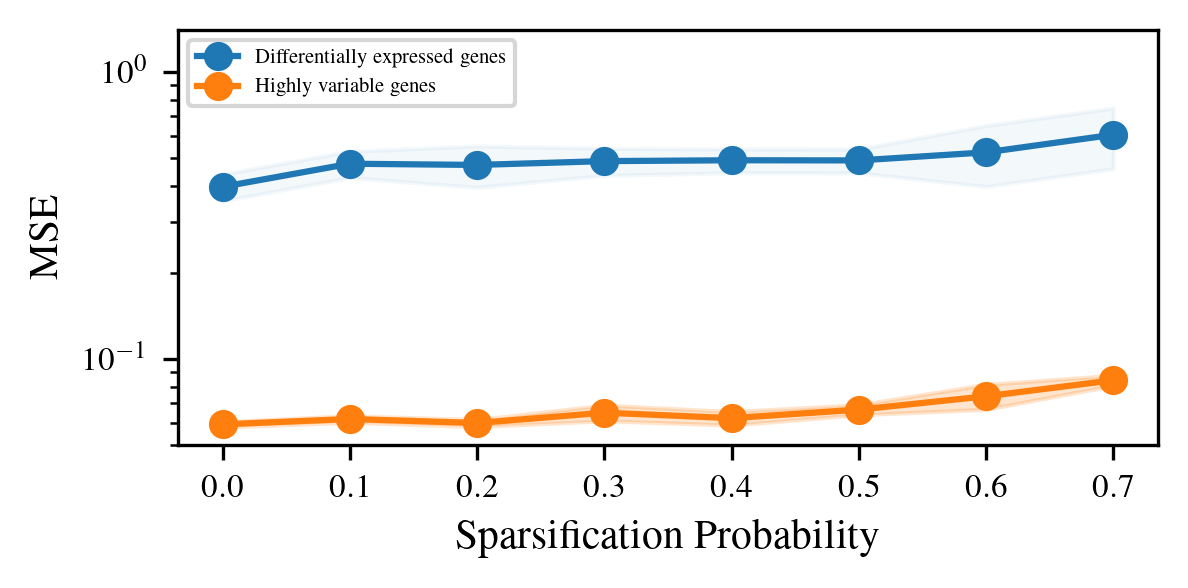

In [408]:
# set dpi = 300 
size = formatter.line_width_plot(aspect_ratio="wide")
print(size)
fig, ax = plt.subplots(figsize=(4, 2), dpi=300)
mean_y = df_mean_ind_grouped['mean_test_mse']
model_y = df_mean_agg_grouped['mean_test_mse']
error_mean = df_mean_ind_grouped['ste_test_mse']
error_model = df_mean_agg_grouped['ste_test_mse']
plot_with_shaded_confidence_intervals(splits, mean_y, model_y, error_mean, error_model, model_name)

In [119]:
# Define a function to run the calculations and store the results for MSE
def collect_mse_results(models):
    results = {
        'model': [],
        'mean_mse': [],
        'ste_mse': []
    }

    for model_name, df_model in models.items():
        mean_mse = df_model['test/mse'].mean()
        ste_mse = df_model['test/mse'].std() / np.sqrt(len(df_model))
        results['model'].append(model_name)
        results['mean_mse'].append(mean_mse)
        results['ste_mse'].append(ste_mse)

    mean_df = pd.DataFrame({
        'model': results['model'],
        'mean_mse': results['mean_mse']
    })

    ste_df = pd.DataFrame({
        'model': results['model'],
        'ste_mse': results['ste_mse']
    })

    return mean_df, ste_df

# Run the function and collect the results in dataframes
models = {
        'scbert': df_scbert_ind,
        'gf': df_gf_ind,
        'scgpt': df_scgpt_ind,
        'scfoundation': df_scf_ind,
        'uce': df_uce_ind, 
        'raw': df_raw_ind, 
        'mean': df_mean_ind,
        'geneformer': df_gf_ind
    }

mean_mse_df, ste_mse_df = collect_mse_results(models)

In [29]:
mean_mse_df

,model,mean_mse
0,scbert,0.456933
1,gf,0.466141
2,scgpt,0.466539
3,scfoundation,0.476357
4,uce,0.462663
5,raw,0.450585
6,mean,0.462153
7,geneformer,0.466141


## Calculate deltaAUSPC for individual level results 

$\Delta$AUSPC = AUSPC_mean - AUSPC_model.

This means if AUSPC_model is smaller than AUSPC_mean, then $\Delta$AUSPC will be positive. This implies that the model is performing better than the mean baseline. 

In [77]:
def trapezoidal_auspc(phi, s, ste):
    auspc = np.trapz(phi, s)
    d = np.diff(s)[0]
    ste = np.sqrt(np.sum((d / 2)**2 * ste**2))
    return auspc, ste

def calculate_delta_auspc(phi_b, phi_m, mean_ste, model_ste, s):
    # Calculate AUSPC for baseline and model using the trapezoidal rule
    auspc_b, ste_b = trapezoidal_auspc(phi_b, s, mean_ste)
    auspc_m, ste_m = trapezoidal_auspc(phi_m, s, model_ste)
    
    # Calculate ΔAUSPC (f_b - f_m)
    delta_auspc = auspc_b - auspc_m
    
    # Calculate ΔAUSPC error using error propagation
    delta_auspc_ste = np.sqrt(ste_b**2 + ste_m**2)
    
    return delta_auspc, delta_auspc_ste

In [78]:
import pandas as pd

def collect_auspc_results(models):
    results = {
        'model': [],
        'mean_auspc': [],
        'ste_auspc': []
    }
    
    s = sorted([float(s) for s in df_mean_ind_grouped['data.split'].unique()])
    for model_name, df_model in models.items():
        phi_m = df_model['mean_test_mse']
        model_test_ste = df_model['ste_test_mse']
        auspc, ste = trapezoidal_auspc(phi_m, s, model_test_ste)
        results['model'].append(model_name)
        results['mean_auspc'].append(auspc)
        results['ste_auspc'].append(ste)

    mean_df = pd.DataFrame({
        'model': results['model'],
        'mean_auspc': results['mean_auspc']
    })

    ste_df = pd.DataFrame({
        'model': results['model'],
        'ste_auspc': results['ste_auspc']
    })

    return mean_df, ste_df

# Run the function and collect the results in dataframes
models = {
        'mean': df_mean_ind_grouped,
        'scbert': df_scbert_ind_grouped,
        'gf': df_gf_ind_grouped,
        'scgpt': df_scgpt_ind_grouped,
        'scfoundation': df_scf_ind_grouped,
        'uce': df_uce_ind_grouped,
        'raw': df_raw_ind_grouped
    }
auspc_ind, ste_df_ind = collect_auspc_results(models)
auspc_ind

,model,mean_auspc
0,mean,0.345187
1,scbert,0.336412
2,gf,0.350821
3,scgpt,0.346870
4,scfoundation,0.350050
5,uce,0.334404
6,raw,0.342071


In [79]:
ste_df_ind

,model,ste_auspc
0,mean,0.011657
1,scbert,0.011416
2,gf,0.013826
3,scgpt,0.014927
4,scfoundation,0.011478
5,uce,0.011545
6,raw,0.012514


In [81]:
models_two_gene = {
        'mean': df_mean_ind_two_grouped,
        'raw': df_raw_ind_two_grouped,
        'uce': df_uce_ind_two_grouped,
        'scgpt': df_scgpt_ind_two_grouped,
        'gf': df_gf_ind_two_grouped,
        'scbert': df_scbert_ind_two_grouped
    }
auspc_ind_two_gene, ste_df_ind_two_gene = collect_auspc_results(models_two_gene)
auspc_ind_two_gene

,model,mean_auspc
0,mean,0.046476
1,raw,0.046476
2,uce,0.418138
3,scgpt,0.501056
4,gf,0.415817
5,scbert,0.428243


In [82]:
ste_df_ind_two_gene

,model,ste_auspc
0,mean,0.005041
1,raw,0.004842
2,uce,0.007358
3,scgpt,0.017711
4,gf,0.007503
5,scbert,0.008085


In [100]:
def collect_delta_auspc_results(models, mean_df):
    results = {
        'model': [],
        'mean_delta_auspc': [],
        'ste_delta_auspc': []
    }
    
    s = sorted([float(s) for s in mean_df['data.split'].unique()])
    phi_b = mean_df['mean_test_mse']
    mean_test_ste = mean_df['ste_test_mse']
    for model_name, df_model in models.items():
        phi_m = df_model['mean_test_mse']
        model_test_ste = df_model['ste_test_mse']
        mean_delta_auspc, ste_delta_auspc = calculate_delta_auspc(phi_b, phi_m, mean_test_ste, model_test_ste, s)
        results['model'].append(model_name)
        results['mean_delta_auspc'].append(mean_delta_auspc)
        results['ste_delta_auspc'].append(ste_delta_auspc)

    mean_df = pd.DataFrame({
        'model': results['model'],
        'mean_delta_auspc': results['mean_delta_auspc']
    })

    ste_df = pd.DataFrame({
        'model': results['model'],
        'ste_delta_auspc': results['ste_delta_auspc']
    })

    return mean_df, ste_df

# Run the function and collect the results in dataframes
models = {
        'scbert': df_scbert_ind_grouped,
        'gf': df_gf_ind_grouped,
        'scgpt': df_scgpt_ind_grouped,
        'scfoundation': df_scf_ind_grouped,
        'uce': df_uce_ind_grouped,
        'raw': df_raw_ind_grouped
    }
delta_auspc, ste_df = collect_delta_auspc_results(models, df_mean_ind_grouped)

In [101]:
delta_auspc

,model,mean_delta_auspc
0,scbert,0.008775
1,gf,-0.005635
2,scgpt,-0.001683
3,scfoundation,-0.004864
4,uce,0.010783
5,raw,0.003116


In [102]:
ste_df

,model,ste_delta_auspc
0,scbert,0.016316
1,gf,0.018084
2,scgpt,0.018940
3,scfoundation,0.016360
4,uce,0.016407
5,raw,0.017102


In [103]:
delta_auspc_two, ste_df_two = collect_delta_auspc_results(models_two_gene, df_mean_ind_two_grouped)
delta_auspc_two

,model,mean_delta_auspc
0,mean,0.000000e+00
1,raw,4.656613e-11
2,uce,-3.716625e-01
3,scgpt,-4.545800e-01
4,gf,-3.693411e-01
5,scbert,-3.817671e-01


In [92]:
ste_df_two

,model,ste_delta_auspc
0,mean,0.012701
1,raw,0.012623
2,uce,0.013785
3,scgpt,0.021204
4,gf,0.013863
5,scbert,0.014187


In [812]:
import pandas as pd

def collect_auspc_results_agg():
    results = {
        'model': [],
        'mean_auspc': [],
        'ste_auspc': []
    }

    models = {
        'mean': df_mean_agg_grouped,
        'scbert': df_scbert_agg_grouped,
        'gf': df_gf_agg_grouped,
        'scgpt': df_scgpt_agg_grouped,
        'scfoundation': df_scf_agg_grouped,
        'uce': df_uce_agg_grouped,
        'raw': df_raw_agg_grouped
    }
    
    s = sorted([float(s) for s in df_mean_ind_grouped['data.split'].unique()])
    for model_name, df_model in models.items():
        phi_m = df_model['mean_test_mse']
        model_test_ste = df_model['ste_test_mse']
        auspc, ste = trapezoidal_auspc(phi_m, s, model_test_ste)
        results['model'].append(model_name)
        results['mean_auspc'].append(auspc)
        results['ste_auspc'].append(ste)

    mean_df = pd.DataFrame({
        'model': results['model'],
        'mean_auspc': results['mean_auspc']
    })

    ste_df = pd.DataFrame({
        'model': results['model'],
        'ste_auspc': results['ste_auspc']
    })

    return mean_df, ste_df

# Run the function and collect the results in dataframes
auspc_agg, ste_df_agg = collect_auspc_results_agg()
auspc_agg

,model,mean_auspc
0,mean,0.046117
1,scbert,0.045369
2,gf,0.046513
3,scgpt,0.045254
4,scfoundation,0.045938
5,uce,0.046472
6,raw,0.044626


In [793]:
ste_df_agg

,model,ste_auspc
0,mean,0.000519
1,scbert,0.000445
2,gf,0.000499
3,scgpt,0.000428
4,scfoundation,0.000444
5,uce,0.000505
6,raw,0.000512


In [814]:
# calculate the deltaAUSPC from the aggregated results auspc_agg df by subtracting the mean_auspc for the 'mean' model from the mean_auspc for each model
delta_auspc_agg = auspc_agg.copy()
delta_auspc_agg['mean_delta_auspc'] =  auspc_agg.loc[auspc_agg['model'] == 'mean', 'mean_auspc'].values[0] - delta_auspc_agg['mean_auspc']
delta_auspc_agg


,model,mean_auspc,mean_delta_auspc
0,mean,0.046117,0.000000
1,scbert,0.045369,0.000748
2,gf,0.046513,-0.000396
3,scgpt,0.045254,0.000863
4,scfoundation,0.045938,0.000179
5,uce,0.046472,-0.000355
6,raw,0.044626,0.001490
